In [ ]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from PIL import Image

SEED = 1234

In [ ]:
# install skorch
!pip install skorch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 5.6 MB/s eta 0:00:00


Exploratory Data Analysis
The file Folds.csv contains all image files' path and filename. It includes a 5-fold cross-validation strategy. I will read it into a dataframe and find each file's main type label(benign or malignant) and sub-type label.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fold_data = pd.read_csv("/content/drive/MyDrive/DL/aptos_kaggle/train2.csv")
# Get the real path of file in kaggle
fold_data['filename'] = ("/content/drive/MyDrive/DL/aptos_claheBen20-225/train_images/"+fold_data["id_code"]+".png")
#Find the main type label and sub type label for each image
fold_data["diagnosis"] = fold_data["diagnosis"]
fold_data

,id_code,diagnosis,filename
0,000c1434d8d7,2,/content/drive/MyDrive/DL/aptos_claheBen20-225...
1,001639a390f0,4,/content/drive/MyDrive/DL/aptos_claheBen20-225...
2,0024cdab0c1e,1,/content/drive/MyDrive/DL/aptos_claheBen20-225...
3,002c21358ce6,0,/content/drive/MyDrive/DL/aptos_claheBen20-225...
4,005b95c28852,0,/content/drive/MyDrive/DL/aptos_claheBen20-225...
...,...,...,...
3656,ffa47f6a7bf4,2,/content/drive/MyDrive/DL/aptos_claheBen20-225...
3657,ffc04fed30e6,0,/content/drive/MyDrive/DL/aptos_claheBen20-225...
3658,ffcf7b45f213,2,/content/drive/MyDrive/DL/aptos_claheBen20-225...
3659,ffd97f8cd5aa,0,/content/drive/MyDrive/DL/aptos_claheBen20-225...


In [ ]:
#Split it into train set(90%) and test set(10%)
img_data = fold_data
test = img_data.sample(frac=0.1,random_state=123)
train = img_data.drop(test.index)
train.reset_index(inplace=True)
train.drop(columns=['index'],inplace=True)
test.reset_index(inplace=True)
test.drop(columns=['index'],inplace=True)
train.shape,test.shape

((3295, 3), (366, 3))

In [ ]:
from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# y_train2 = le.fit_transform(train.main_type)
# y_test2 = le.transform(test.main_type)
# main_classname = list(le.classes_)

le1 = preprocessing.LabelEncoder()
y_train8 = le1.fit_transform(train.diagnosis)
y_test8 = le1.transform(test.diagnosis)
sub_classname = list(le1.classes_)


y_train8,y_test8

(array([2, 4, 1, ..., 2, 0, 2]),
 array([0, 0, 2, 4, 0, 2, 0, 2, 0, 1, 1, 2, 1, 0, 4, 2, 2, 3, 0, 0, 0, 2,
        0, 2, 0, 0, 4, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 4, 0, 2, 0,
        0, 0, 1, 0, 0, 2, 0, 0, 1, 3, 2, 0, 2, 4, 2, 0, 0, 4, 0, 0, 0, 1,
        0, 0, 2, 0, 2, 0, 0, 2, 0, 4, 4, 0, 0, 2, 0, 3, 4, 1, 4, 3, 0, 2,
        0, 4, 2, 0, 0, 4, 1, 0, 0, 0, 4, 0, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2,
        0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 1, 2, 0,
        2, 2, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 4, 0, 1, 0, 0,
        0, 0, 2, 0, 1, 2, 0, 0, 0, 1, 4, 0, 0, 0, 2, 1, 0, 0, 4, 0, 2, 1,
        0, 0, 0, 2, 0, 2, 2, 0, 3, 3, 0, 0, 3, 2, 0, 2, 2, 2, 4, 2, 3, 0,
        0, 2, 0, 0, 2, 0, 4, 0, 4, 0, 0, 2, 0, 0, 4, 0, 0, 4, 0, 1, 2, 0,
        4, 2, 2, 0, 2, 2, 3, 0, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0,
        4, 2, 1, 3, 0, 1, 0, 2, 1, 4, 2, 0, 3, 1, 0, 4, 0, 2, 1, 0, 0, 0,
        0, 4, 2, 1, 0, 0, 0, 0, 0, 3, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0,
     

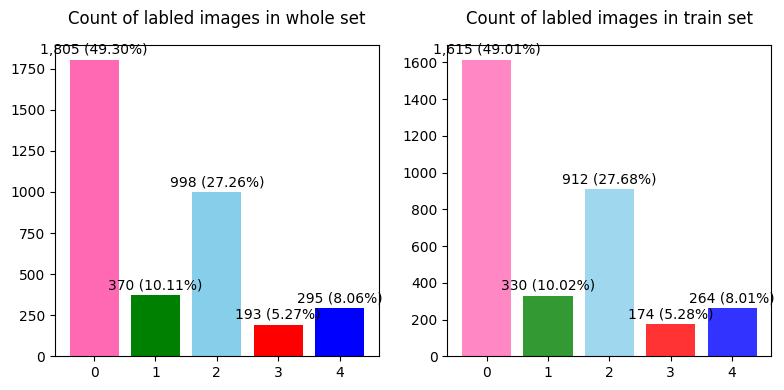

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), tight_layout=True)

# Plot image count/prop in each main type
main_whole = img_data["diagnosis"].value_counts(ascending=True)
ax[0].bar(main_whole.index,main_whole,color=["red", "blue","green","skyblue", "hotpink"])
ax[0].bar_label(ax[0].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(img_data):.2%})" for x in main_whole])
ax[0].set_title("Count of labled images in whole set", size=12, pad=15)

# Plot image count/prop in each sub type
main_train = train["diagnosis"].value_counts(ascending=True)
ax[1].bar(main_train.index,main_train,color=["red", "blue","green","skyblue", "hotpink"], alpha=0.8)
ax[1].bar_label(ax[1].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in main_train])
ax[1].set_title("Count of labled images in train set", size=12, pad=15)
plt.show()

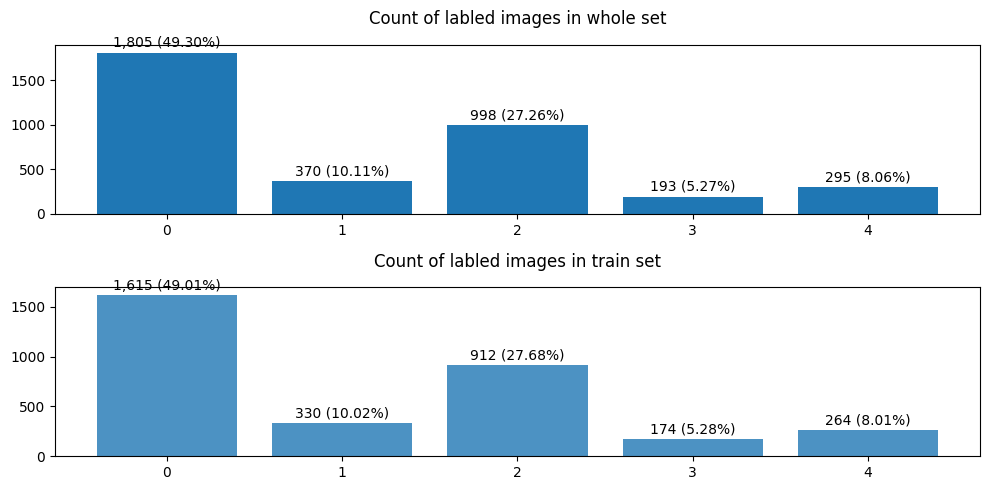

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 5), tight_layout=True)
# Plot image count/prop in each sub type for whole set
sub_whole = img_data["diagnosis"].value_counts(ascending=True)
ax[0].bar(sub_whole.index,sub_whole)
ax[0].bar_label(ax[0].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(img_data):.2%})" for x in sub_whole])
ax[0].set_title("Count of labled images in whole set", size=12, pad=15)

# Plot image count/prop in each sub type for train set
sub_train = train["diagnosis"].value_counts(ascending=True)
ax[1].bar(sub_train.index,sub_train, alpha=0.8)
ax[1].bar_label(ax[1].containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in sub_train])
ax[1].set_title("Count of labled images in train set", size=12, pad=15)
plt.show()

In [ ]:
from torch.utils.data import DataLoader
IMG_SIZE = 224
BATCH_SIZE = 32
#
# Define class to load image data
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df,y):
        self.X = X_df
        self.y = y
        self.T = transforms.Compose([
                    transforms.Resize(IMG_SIZE),
                    transforms.CenterCrop(IMG_SIZE),
                    transforms.ToTensor()])
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        return self.T(img),self.y[index]


# load data batch by bathc
loader = DataLoader(
  load_data(train,y_train8),
  batch_size = 16)

y_train8.shape

(3295,)

In [ ]:

def  img_mean_and_sd(loader):

    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])

        #comput first and second moment batch by batch
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    img_mean, img_std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
    return img_mean,img_std

#img_mean, img_std = img_mean_and_sd(loader)
#print("Images' mean and std: \n", img_mean, img_std)



#10%#updated for ClaheBen20
img_mean=[0.4925, 0.4914, 0.4886]
img_std=[0.1610, 0.1615, 0.1243]

In [ ]:
# Define class to load and transform image data
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df, y):
        self.X = X_df
        self.y = y
        self.T1 = transforms.Compose([
                    transforms.CenterCrop(IMG_SIZE),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])
        self.T2 = transforms.Compose([
                    transforms.CenterCrop(IMG_SIZE),
                    transforms.Resize(IMG_SIZE),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        if self.X.name == 'train': return self.T1(img),self.y[index]
        else: return self.T2(img),self.y[index]


# Prepare training and validation datasets for 8-class classfication
X_train_8, X_valid_8, y_train_8, y_valid_8 = train_test_split(train, y_train8, test_size=0.25, random_state=SEED)
X_train_8.name = 'train'
X_valid_8.name = 'val'
test.name = 'test'

# reset index
X_train_8.reset_index(inplace=True)
X_train_8.drop(columns=['index'],inplace=True)
X_valid_8.reset_index(inplace=True)
X_valid_8.drop(columns=['index'],inplace=True)

train_ds_8 = load_data(X_train_8,y_train_8)
valid_ds_8 = load_data(X_valid_8,y_valid_8)
test_ds_8 = load_data(test,y_test8)


print(X_train_8.shape, X_valid_8.shape, y_train_8.shape, y_valid_8.shape)


(2471, 3) (824, 3) (2471,) (824,)


In [ ]:
#Build resnet50 pretrained model
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
             nn.Linear(num_ftrs, 1000),
             nn.ReLU(),
             nn.Linear(1000, 128),
             nn.ReLU(),
             nn.Linear(128, output_features)
        )
        self.model = model


    def forward(self, x):
        return self.model(x)

DEVICE = 'cuda'


#prenet = PretrainedModel(2)
print('Pretrained model ready!')


Pretrained model ready!


In [ ]:
# #https://www.kaggle.com/code/ashfakyeafi/neural-style-transfer-pytorch

# from torchvision.models import vgg19, VGG19_Weights

# class VGG(nn.Module):
#     def __init__(self):
#         super(VGG, self).__init__()

#         self.chosen_features = ["0", "5", "10", "19", "28"]
#         #self.model = models.vgg19(pretrained=True).features[:29]
#         self.model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

#     def forward(self, x):
#         features = []

#         for layer_num, layer in enumerate(self.model):
#             x = layer(x)

#             if str(layer_num) in self.chosen_features:
#                 features.append(x)

#         return features

# print(' VGG19 Pretrained model ready!')

In [ ]:
class HXVGG19(nn.Module):
  def __init__(self, num_classes=5):
    super().__init__()
    self.model = torchvision.models.vgg19(pretrained=True)
    in_features = self.model.classifier[-1].in_features
    self.model.classifier[-1] = nn.Linear(in_features, num_classes)

  def forward(self, x):
    return self.model(x)
a = HXVGG19()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 167MB/s]


In [ ]:
model = torchvision.models.vgg19(pretrained=True)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
#https://www.kaggle.com/code/muhammadimran112233/transfer-learning-brain-tumor-classification
VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']
}
class VGGnet(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=10, init_weights=True):
        super(VGGnet,self).__init__()
        self.in_channels = in_channels

        # create conv_layers corresponding to VGG type
        self.conv_layers = self.create_conv_laters(VGG_types[model])

        self.fcs = nn.Sequential(
            nn.Linear(1536, 1536//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1536//2, 1536//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1536//2, num_classes),
        )

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fcs(x)
        return x

    # defint weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    # define a function to create conv layer taken the key of VGG_type dict
    def create_conv_laters(self, architecture):
        layers = []
        in_channels = self.in_channels # 3

        for x in architecture:
            if type(x) == int: # int means conv layer
                out_channels = x

                layers += [nn.Conv3d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=(3,2,3), stride=(1,1,1), padding=(1,1,1)),
                           nn.BatchNorm3d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool3d(kernel_size=(2,2,2), stride=(2,2,2))]

        return nn.Sequential(*layers)

DEVICE = 'cuda'

# create VGGnet object
# Choose between 'VGG11', 'VGG13', 'VGG16', 'VGG19'
model_vgg19 = VGGnet('VGG19', in_channels=3, num_classes=5, init_weights=True).to(DEVICE)
#print(model_vgg19)

In [ ]:
from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer
from torch.optim.lr_scheduler import CyclicLR

lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.3)

freezer = Freezer(lambda x: not x.startswith('model.fc'))


In [ ]:
# #Train model with SDG optimizer for 5 classes case
# #Train the model with step LR scheduler and validate with predefined validation set

# checkpoint = Checkpoint(dirname='/content/drive/MyDrive/DL/aptos_ben_clahe224_Result/SGD')
# lrscheduler = LRScheduler(policy=CyclicLR,base_lr=0.001, max_lr=0.5,step_size_up=len(train_ds_8)//2)
# net2 = NeuralNetClassifier(
#     PretrainedModel(5),
#     criterion=nn.CrossEntropyLoss,
#     lr=0.001,
#     batch_size=16,
#     max_epochs=20,
#     module__output_features=5,
#     optimizer=optim.SGD,
#     optimizer__momentum=0.9,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(valid_ds_8),
#     callbacks=[lrscheduler, checkpoint, freezer],
#     device = 'cuda'
# )
# _ = net2.fit(train_ds_8,y=None)


In [ ]:
# #SGD: plot the train and validation loss curve
# val_loss=[]
# train_loss=[]
# net2.initialize()
# net2.load_params(f_params='/content/drive/MyDrive/DL/aptos_kaggle/SGD/params.pt',
#                 f_history='/content/drive/MyDrive/DL/aptos_kaggle/SGD/history.json')
# for i in range(25):
#     val_loss.append(net2.history[i]['valid_loss'])
#     train_loss.append(net2.history[i]['train_loss'])

# plt.figure(figsize=(8,6))
# plt.semilogy(train_loss, label='Train loss')
# plt.semilogy(val_loss, label='Validation loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid()
# plt.legend()
# plt.show()

In [ ]:
# #Train model with Adam optimizer for 5 classes case
# #Train the model with step LR scheduler and validate with predefined validation set

# lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.5)
# cp = Checkpoint(dirname='/content/drive/MyDrive/DL/aptos_ben_clahe224/Adam')
# train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/DL/aptos_ben_clahe224/Adam')

# net = NeuralNetClassifier(
#     PretrainedModel(5),
#     criterion=nn.CrossEntropyLoss,
#     lr=0.0003,
#     batch_size=32,
#     max_epochs=30,
#     optimizer=optim.Adam,
#     optimizer__weight_decay=1e-4,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(valid_ds_8),
#     callbacks=[lrscheduler,cp,train_end_cp],
#     device = 'cuda'

# )

# _ = net.fit(train_ds_8,y=None)

In [ ]:
# #Adam: plot the train and validation loss curve
# val_loss=[]
# train_loss=[]
# net.initialize()
# net.load_params(f_params='/content/drive/MyDrive/DL/aptos_kaggle/Adam/train_end_params.pt',
#                 f_history='/content/drive/MyDrive/DL/aptos_kaggle/Adam/train_end_history.json')
# for i in range(30):
#     val_loss.append(net.history[i]['valid_loss'])
#     train_loss.append(net.history[i]['train_loss'])

# plt.figure(figsize=(8,6))
# plt.semilogy(train_loss, label='Train loss')
# plt.semilogy(val_loss, label='Validation loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid()
# plt.legend()
# plt.show()

In [ ]:
# #Prediction of 5-class classifier
# from sklearn.metrics import accuracy_score
# #from sklearn.model_selection import cross_val_score

# net.initialize()
# net.load_params(f_params='/content/drive/MyDrive/DL/aptos_kaggle/Adam/train_end_params.pt')

# y_pred8 = net.predict(test_ds_8)
# accuracy8 = accuracy_score(y_test8, y_pred8)
# print(f'The test accuracy for 5-class classification: {round(accuracy8*100,2)}%')

In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
#len(train_ds_8)

In [ ]:
# from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# from sklearn.metrics import classification_report

# cm = confusion_matrix(y_test8, y_pred8)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sub_classname)
# disp.plot()
# plt.show()
# sub_classname_str = [str(x) for x in sub_classname]
# print(classification_report(y_test8, y_pred8, target_names=sub_classname_str, digits=4))
# per_class_accuracies = {}
# for idx, cls in enumerate(sub_classname):
#     true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
#     true_positives = cm[idx, idx]
#     per_class_accuracies[cls] = round((true_positives + true_negatives) / np.sum(cm)*100,2)
#     print(f'Accuracy for {cls}: {per_class_accuracies[cls]}% ')

Prepare the balanced data
Over-sampling using SMOTE

Perform over-sampling using SMOTE to increase minority class size to be same as majority class 'DC'.

In [ ]:
from imblearn.over_sampling import SMOTEN
print(f'The train set shape before over-sampling: {train.shape}')
smote = SMOTEN(sampling_strategy='auto',random_state=SEED)
Xtrain_sm,ytrain_sm8 = smote.fit_resample(train,y_train8)
#ytrain_sm2 = le.transform(Xtrain_sm.main_type)
print(f"After over sampling, the train set shape : {Xtrain_sm.shape}")

The train set shape before over-sampling: (3295, 3)
After over sampling, the train set shape : (8075, 3)


In [ ]:
Xtrain_sm.diagnosis.value_counts()

2    1615
4    1615
1    1615
0    1615
3    1615
Name: diagnosis, dtype: int64

Load and transform the image data
Apply RandomHorizontalFlip() and transforms.RandomVerticalFlip() during loading data to reduce duplicates when add more images for minority class.

In [ ]:
# Define class to load and transform image data
SEED = 31
torch.manual_seed(SEED)
class load_data(torch.utils.data.Dataset):
    def __init__(self, X_df, y):
        self.X = X_df
        self.y = y
        self.T1 = transforms.Compose([
                    transforms.Resize((IMG_SIZE,IMG_SIZE)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(20),
                    transforms.RandomRotation(60),
                    transforms.RandomRotation(90),
                    transforms.RandomRotation(140),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])
        self.T2 = transforms.Compose([
                    transforms.Resize((IMG_SIZE,IMG_SIZE)),
                    transforms.ToTensor(),
                    transforms.Normalize(img_mean,img_std)])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        row = self.X.iloc[index]
        img = Image.open(row['filename'])
        if self.X.name == 'train': return self.T1(img),self.y[index]
        else: return self.T2(img),self.y[index]

# # Prepare training and validation datasets for binary classfication
# X_train, X_valid, y_train, y_valid = train_test_split(Xtrain_sm, ytrain_sm2, test_size=0.25, random_state=SEED)
# X_train.name = 'train'
# X_valid.name = 'val'
# test.name = 'test'
# train.name = 'train'

# # reset index
# X_train.reset_index(inplace=True)
# X_train.drop(columns=['index'],inplace=True)
# X_valid.reset_index(inplace=True)
# X_valid.drop(columns=['index'],inplace=True)

# train_ds_sm = load_data(X_train,y_train)
# valid_ds_sm = load_data(X_valid,y_valid)
# test_ds = load_data(test,y_test2)

# Prepare training and validation datasets for 8-class classfication, 20% for test
X_train_8, X_valid_8, y_train_8, y_valid_8 = train_test_split(Xtrain_sm, ytrain_sm8, test_size=0.1, random_state=SEED)
X_train_8.name = 'train'
X_valid_8.name = 'val'
test.name = 'test'

# reset index
X_train_8.reset_index(inplace=True)
X_train_8.drop(columns=['index'],inplace=True)
X_valid_8.reset_index(inplace=True)
X_valid_8.drop(columns=['index'],inplace=True)

train_ds_sm8 = load_data(X_train_8,y_train_8)
valid_ds_sm8 = load_data(X_valid_8,y_valid_8)
test_ds_8 = load_data(test,y_test8)

In [ ]:
from skorch.callbacks import LRScheduler,Checkpoint,TrainEndCheckpoint,Freezer, ProgressBar, EarlyStopping, Checkpoint, EpochScoring
from torch.optim.lr_scheduler import CyclicLR

lrscheduler = LRScheduler(policy='StepLR', step_size=7, gamma=0.3)

freezer = Freezer(lambda x: not x.startswith('model.fc'))
checkpoint = Checkpoint(dirname='/content/drive/MyDrive/DL/aptos_claheBen20-225/Adam_sm8_vgg2', monitor='valid_loss_best')
early_stopping = EarlyStopping(monitor='valid_loss', patience=5)

Train model with Adam optimizer for 5 classes case
Train the model with step LR scheduler and validate with predefined validation set

In [ ]:
lrscheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.5)
cp = Checkpoint(dirname='/content/drive/MyDrive/DL/aptos_claheBen20-225/Adam_sm8_vgg2')
train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/DL/aptos_claheBen20-225/Adam_sm8_vgg2')
model_vgg19 = HXVGG19()

net = NeuralNetClassifier(
    model_vgg19,
    criterion=nn.CrossEntropyLoss,
    lr=0.00001,
    batch_size=32,
    max_epochs=50,
    optimizer=optim.Adam,
    optimizer__weight_decay=1e-4,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds_sm8),
    callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, EpochScoring(scoring='accuracy', on_train=True)],
    #callbacks=[lrscheduler,cp,train_end_cp, ProgressBar(), checkpoint, early_stopping, EpochScoring(scoring='accuracy', on_train=True)],
    device = 'cuda'
)

_ = net.fit(train_ds_sm8,y=None)
#net.initialize()
#net.load_params(f_params='/content/drive/MyDrive/DL/aptos_claheBen20-225/Adam_sm8_vgg/params.pt')

  epoch    accuracy    train_loss    valid_acc    valid_loss    cp      lr       dur
-------  ----------  ------------  -----------  ------------  ----  ------  --------
      1      0.7948        0.6062       0.8824        0.6093     +  0.0000  753.6553


      2      0.8829        0.3324       0.8960        0.4136     +  0.0000  45.2640


      3      0.8918        0.2947       0.8923        0.3186     +  0.0000  47.0355


      4      0.9017        0.2647       0.9022        0.3037     +  0.0000  46.7548


      5      0.9062        0.2556       0.9097        0.2542     +  0.0000  47.0148


      6      0.9108        0.2354       0.9059        0.2661        0.0000  46.9278


      7      0.9108        0.2334       0.9059        0.2685        0.0000  45.3284


      8      0.9163        0.2255       0.9146        0.2735        0.0000  45.2851


      9      0.9150        0.2271       0.9121        0.2603        0.0000  45.4256


     10      0.9195        0.2172       0.9121        0.2565        0.0000  45.2692


     11      0.9184        0.2067       0.9171        0.2381     +  0.0000  45.6640


     12      0.9221        0.2025       0.9035        0.2656        0.0000  46.8471


     13      0.9205        0.2036       0.9158        0.2298     +  0.0000  45.5063


     14      0.9247        0.1972       0.9109        0.2442        0.0000  47.2405


     15      0.9207        0.1988       0.9146        0.2384        0.0000  45.4037


     16      0.9253        0.1925       0.9146        0.2411        0.0000  45.3764


     17      0.9267        0.1865       0.9121        0.2559        0.0000  45.3777


     18      0.9271        0.1840       0.9146        0.2424        0.0000  45.1929


     19      0.9236        0.1928       0.9171        0.2354        0.0000  45.1993


     20      0.9286        0.1841       0.9121        0.2436        0.0000  45.2414


     21      0.9298        0.1794       0.9146        0.2407        0.0000  45.1457


     22      0.9305        0.1813       0.9171        0.2450        0.0000  45.1190


     23      0.9302        0.1812       0.9171        0.2446        0.0000  45.2806


     24      0.9278        0.1826       0.9146        0.2347        0.0000  45.3308


     25      0.9282        0.1806       0.9146        0.2394        0.0000  45.0893


     26      0.9295        0.1796       0.9146        0.2421        0.0000  45.2672


     27      0.9293        0.1785       0.9134        0.2441        0.0000  45.1178


     28      0.9312        0.1747       0.9158        0.2392        0.0000  45.3538


     29      0.9273        0.1798       0.9146        0.2421        0.0000  45.3934


     30      0.9283        0.1771       0.9158        0.2425        0.0000  45.4670


     31      0.9295        0.1765       0.9158        0.2419        0.0000  45.3020


     32      0.9284        0.1785       0.9146        0.2433        0.0000  45.3773


     33      0.9338        0.1741       0.9146        0.2425        0.0000  45.4042


     34      0.9339        0.1745       0.9158        0.2441        0.0000  45.3769


     35      0.9306        0.1731       0.9146        0.2428        0.0000  45.3684


     36      0.9295        0.1763       0.9146        0.2419        0.0000  45.4671


     37      0.9323        0.1703       0.9146        0.2418        0.0000  45.4001


     38      0.9330        0.1747       0.9146        0.2416        0.0000  45.2310


     39      0.9327        0.1709       0.9146        0.2435        0.0000  45.2687


     40      0.9338        0.1724       0.9146        0.2421        0.0000  45.3477


     41      0.9298        0.1774       0.9146        0.2417        0.0000  45.2950


     42      0.9297        0.1768       0.9146        0.2421        0.0000  45.3239


     43      0.9309        0.1748       0.9146        0.2423        0.0000  45.3962


     44      0.9330        0.1709       0.9146        0.2427        0.0000  45.4305


     45      0.9312        0.1766       0.9146        0.2427        0.0000  45.3154


     46      0.9289        0.1781       0.9146        0.2424        0.0000  45.3332


     47      0.9284        0.1768       0.9146        0.2427        0.0000  45.3384


     48      0.9319        0.1750       0.9146        0.2426        0.0000  45.3908


     49      0.9289        0.1794       0.9146        0.2423        0.0000  45.3255


     50      0.9322        0.1729       0.9146        0.2420        0.0000  45.7014


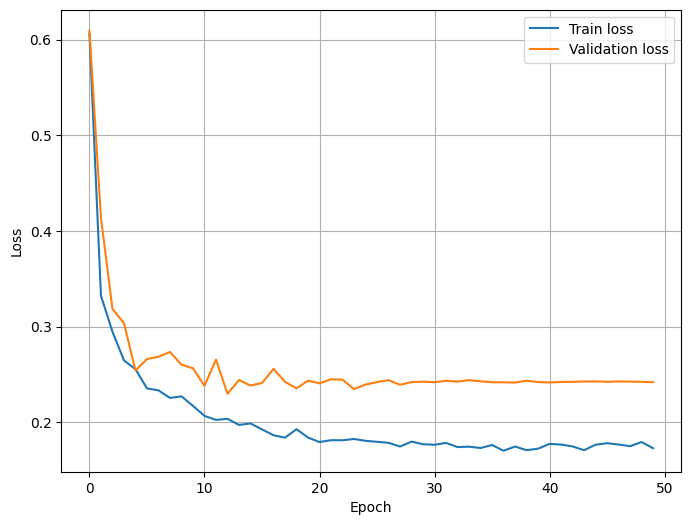

In [ ]:
val_loss=[]
train_loss=[]

# net.initialize()
# net.load_params(f_params='/content/drive/MyDrive/DL/aptos_claheBen20-225/Adam_sm8_vgg1/train_end_params.pt',
#                 f_history='/content/drive/MyDrive/DL/aptos_claheBen20-225/Adam_sm8_vgg1/train_end_history.json')
for i in range(50):
    val_loss.append(net.history[i]['valid_loss'])
    train_loss.append(net.history[i]['train_loss'])

plt.figure(figsize=(8,6))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

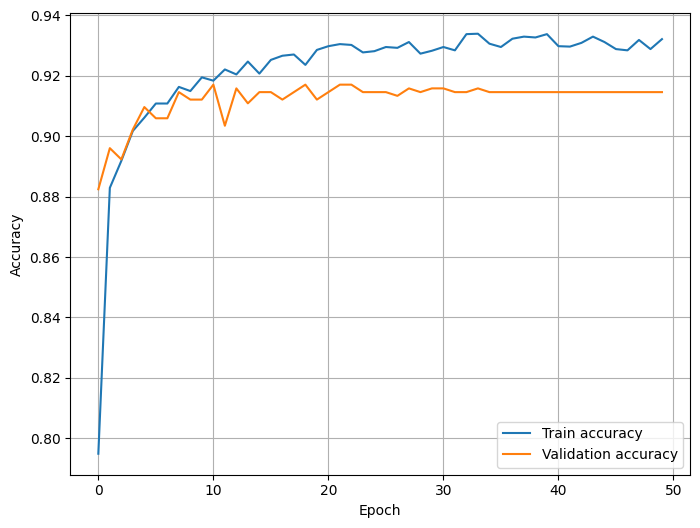

In [ ]:
val_acc=[]
train_acc=[]

for i in range(50):
    val_acc.append(net.history[i]['valid_acc'])
    train_acc.append(net.history[i]['accuracy'])

plt.figure(figsize=(8,6))
plt.plot(train_acc, label='Train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()



In [ ]:
#Prediction of 5-class classifier
from sklearn.metrics import accuracy_score

# lrscheduler = LRScheduler(policy=CyclicLR,base_lr=0.001, max_lr=0.5,step_size_up=len(train_ds_sm8)//2)
# cp = Checkpoint(dirname='/content/drive/MyDrive/DL/aptos_clahe_GFPGAN224/Adam2_sm8')
# train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/DL/aptos_clahe_GFPGAN224/Adam2_sm8')

# net = NeuralNetClassifier(
#     PretrainedModel(5),
#     criterion=nn.CrossEntropyLoss,
#     lr=0.0003,
#     batch_size=32,
#     max_epochs=20,
#     optimizer=optim.Adam,
#     optimizer__weight_decay=1e-4,
#     iterator_train__shuffle=True,
#     iterator_train__num_workers=2,
#     iterator_valid__shuffle=False,
#     iterator_valid__num_workers=2,
#     train_split=predefined_split(valid_ds_sm8),
#     callbacks=[lrscheduler,cp,train_end_cp],
#     device = 'cuda'
# )


# net.initialize()
# net.load_params(f_params='/content/drive/MyDrive/DL/aptos_GFPGAN224/Adam2_sm8/train_end_params.pt')


y_pred8 = net.predict(test_ds_8)
accuracy8 = accuracy_score(y_test8, y_pred8)
print(f'The test accuracy for 5-class classification: {round(accuracy8*100,2)}%')

The test accuracy for 5-class classification: 81.69%


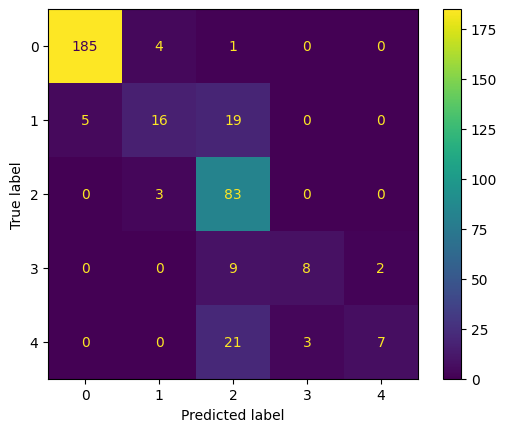

              precision    recall  f1-score   support

           0     0.9737    0.9737    0.9737       190
           1     0.6957    0.4000    0.5079        40
           2     0.6241    0.9651    0.7580        86
           3     0.7273    0.4211    0.5333        19
           4     0.7778    0.2258    0.3500        31

    accuracy                         0.8169       366
   macro avg     0.7597    0.5971    0.6246       366
weighted avg     0.8318    0.8169    0.7964       366

Accuracy for 0: 97.27% 
Accuracy for 1: 91.53% 
Accuracy for 2: 85.52% 
Accuracy for 3: 96.17% 
Accuracy for 4: 92.9% 


In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test8, y_pred8)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sub_classname)
disp.plot()
plt.show()
sub_classname_str = [str(x) for x in sub_classname]
print(classification_report(y_test8, y_pred8, target_names=sub_classname_str, digits=4))
per_class_accuracies = {}
for idx, cls in enumerate(sub_classname):
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    true_positives = cm[idx, idx]
    per_class_accuracies[cls] = round((true_positives + true_negatives) / np.sum(cm)*100,2)
    print(f'Accuracy for {cls}: {per_class_accuracies[cls]}% ')


In [ ]:
cm

array([[178,   3,   8,   1,   0],
       [ 10,   2,  28,   0,   0],
       [  6,   1,  78,   1,   0],
       [  1,   0,  18,   0,   0],
       [  2,   1,  25,   1,   2]])

In [ ]:
#Train model with SGD optimizer for 5 classes case
#Train the model with step LR scheduler and validate with predefined validation set

lrscheduler = LRScheduler(policy=CyclicLR,base_lr=0.001, max_lr=0.5,step_size_up=len(train_ds_sm8)//2)
checkpoint = Checkpoint(dirname='/content/drive/MyDrive/DL/aptos_claheBen20-225/SGD_sm8')
train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/DL/aptos_claheBen20-225/SGD_sm8')

net3 = NeuralNetClassifier(
    PretrainedModel(5),
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=30,
    module__output_features=5,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds_8),
    callbacks=[lrscheduler, checkpoint, freezer],
    device = 'cuda'
)
_ = net3.fit(train_ds_sm8,y=None)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        1.5690       0.6333        1.5334     +  0.0010  30.2420
      2        1.1011       0.6212        1.0461     +  0.0011  29.5751
      3        0.5070       0.6545        0.9769     +  0.0013  29.6725
      4        0.4353       0.6727        0.9097     +  0.0014  29.7191
      5        0.4010       0.6848        0.8501     +  0.0015  30.3372
      6        0.3890       0.7091        0.8582        0.0017  30.2230
      7        0.3748       0.6970        0.8765        0.0018  29.7299
      8        0.3587       0.7000        0.8342     +  0.0020  29.1264
      9        0.3536       0.7061        0.8001     +  0.0021  29.7230
     10        0.3385       0.7061        0.7750     +  0.0022  29.6285
     11        0.3438       0.7091        0.8670        0.0024  29.2161
     12        0.3376       0.7152        0.8071        0.0025  

In [ ]:
#Prediction of 5-class classifier

from sklearn.metrics import accuracy_score

lrscheduler = LRScheduler(policy=CyclicLR,base_lr=0.001, max_lr=0.5,step_size_up=len(train_ds_sm8)//2)
checkpoint = Checkpoint(dirname='/content/drive/MyDrive/DL/aptos_claheBen20-225/Adam2_sm8')
train_end_cp = TrainEndCheckpoint(dirname='/content/drive/MyDrive/DL/aptos_claheBen20-225/Adam2_sm8')

net3 = NeuralNetClassifier(
    PretrainedModel(5),
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=20,
    module__output_features=5,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    train_split=predefined_split(valid_ds_8),
    callbacks=[lrscheduler, checkpoint, freezer],
    device = 'cuda'
)
net3.initialize()
net3.load_params(f_params='/content/drive/MyDrive/DL/aptos_claheBen20-225/Adam_sm8/train_end_params.pt')
y_pred8 = net3.predict(test_ds_8)
accuracy8 = accuracy_score(y_test8, y_pred8)
print(f'The test accuracy for 5-class classification: {round(accuracy8*100,2)}%')

The test accuracy for 5-class classification: 78.42%


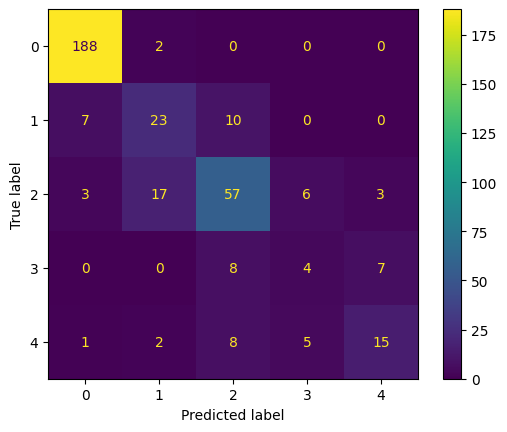

              precision    recall  f1-score   support

           0     0.9447    0.9895    0.9666       190
           1     0.5227    0.5750    0.5476        40
           2     0.6867    0.6628    0.6746        86
           3     0.2667    0.2105    0.2353        19
           4     0.6000    0.4839    0.5357        31

    accuracy                         0.7842       366
   macro avg     0.6042    0.5843    0.5920       366
weighted avg     0.7736    0.7842    0.7777       366

Accuracy for 0: 96.45% 
Accuracy for 1: 89.62% 
Accuracy for 2: 84.97% 
Accuracy for 3: 92.9% 
Accuracy for 4: 92.9% 


In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test8, y_pred8)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sub_classname)
disp.plot()
plt.show()
sub_classname_str = [str(x) for x in sub_classname]
print(classification_report(y_test8, y_pred8, target_names=sub_classname_str, digits=4))
per_class_accuracies = {}
for idx, cls in enumerate(sub_classname):
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    true_positives = cm[idx, idx]
    per_class_accuracies[cls] = round((true_positives + true_negatives) / np.sum(cm)*100,2)
    print(f'Accuracy for {cls}: {per_class_accuracies[cls]}% ')

In [ ]:
cm

array([[188,   2,   0,   0,   0],
       [  7,  23,  10,   0,   0],
       [  3,  17,  57,   6,   3],
       [  0,   0,   8,   4,   7],
       [  1,   2,   8,   5,  15]])